<a href="https://colab.research.google.com/github/Praveen76/Build-YOLO-Model-from-scratch/blob/main/Build_YOLO_Model_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment you will be able to :

* understand what is object detection
* configure a state-of-the-art algorithm called YOLO V3
* make inferences from YOLO on real-time images

## Introduction:


### What is YOLO V3?
YOLOv3 (You Only Look Once, Version 3) is a real-time object detection algorithm that identifies specific objects in videos, live feeds or images. The YOLO machine learning algorithm uses features learned by a deep convolutional neural network to detect an object. YOLO has the advantage of being much faster than other networks and still maintains accuracy.

The approach involves a single deep convolutional neural network (originally a version of GoogLeNet, later updated and called **DarkNet** based on VGG) that splits the input into a grid of cells and each cell directly predicts a bounding box and object classification. The result is a large number of candidate bounding boxes that are consolidated into a final prediction by a post-processing step.

It allows the model to look at the whole image at test time, so its predictions are informed by the global context in the image. Using CNN, YOLO can predict all objects in one forward pass and that is the reason for its full name “You Only Look Once”. You Only Look Once means it looks for the image/frame only once and is able to detect all the objects in the image/frame.

High-scoring regions are noted as positive detections of whatever class they most closely identify with. For example, in a live feed of traffic, YOLO can be used to detect different kinds of vehicles depending on which regions of the video score highly in comparison to predefined classes of vehicles.



### How YOLOv3 works?

The YOLOv3 network divides an input image into an S x S grid of cells and predicts bounding boxes as well as class probabilities for each grid. Each grid cell is responsible for predicting B-bounding boxes and C-class probabilities of objects whose centers fall inside the grid cell. Bounding boxes are the regions of interest (ROI) of the candidate objects. The “B” is associated with the number of using anchors. Each bounding box has (5 + C) attributes. The value of “5” is related to 5 bounding box attributes, which are center coordinates (bx, by) and shape (bh, bw) of the bounding box, and one confidence score. The “C” is the number of classes. The confidence score reflects how confident a box contains an object. The confidence score is in the range of 0 – 1.

Since we have an S x S grid of cells, after running a single forward pass convolutional neural network to the whole image, YOLOv3 produces a 3-D tensor with the shape of [S, S, B * (5 + C].

The following figure illustrates the basic principle of YOLOv3 where the input image is divided into the 13 x 13 grid of cells (13 x 13 grid of cells is used for the first scale, whereas YOLOv3 actually uses 3 different scales and we're going to discuss it in the section prediction across scale).

<center>
<img style="-webkit-user-select: none;margin: auto;" src="https://machinelearningspace.com/wp-content/uploads/2020/01/bbox_ok-2-868x1024.png" width="800" height="800">
</center>

YOLOv3 was trained on the COCO dataset with C=80(class) and B=3(). So, for the first prediction scale, after a single forward pass of CNN, the YOLOv3 outputs a tensor with the shape of [(13, 13, 3 * (5 + 80)].

### Importing required packages

In [1]:
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers import add, concatenate
from keras.models import Model
import struct
import cv2
import keras

### Pre-trained Weights from the repository

Model Weights can be downloaded from the website of the original creator of YOLOv3. The model has already been trained by the authors and thus it is easier to use the pre-trained weights for inference. Download the model weights and place them into your current directory with the filename `“yolov3.weights.”`. These were trained using the DarkNet code base on the MSCOCO dataset.

**Note:** Refer to the following [link](https://pjreddie.com/darknet/yolo/)

In [2]:
#@title Download the pre-trained weight
!wget -qq https://pjreddie.com/media/files/yolov3.weights

### Create a class WeightReader to load the pre-trained weights for yolov3

WeightReader class will parse the file and load the model weights into memory to set it in our Keras model.

We will be reading the original weights of Yolo. The original network was not trained in Keras and thus we define a special class to read weights.

In [3]:
# class to load the pretrained Weights
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)

            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    # Set the model weights into the model
    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance

                    weights = norm_layer.set_weights([gamma, beta, mean, var])

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))

                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0

### YOLO V3 Architecture

YOLO v3 is using a Darknet-53  network to perform feature extraction which is undeniably larger compare to YOLO v2. This network is composed of 53 convolutional layers with shortcut connections (Redmon & Farhadi, 2018).

The code implementation is composed of several components as given below:

<center>
<img style="-webkit-user-select: none;margin: auto;" src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*-Whes2CytS_v22Wx1LZ6RA.png" width="500
" height="700">
</center>

The 53 layers of the darknet are further stacked with 53 more layers for the detection head, making YOLO v3 a total of a 106-layer fully convolutional underlying architecture. This leading to a large architecture, though making it a bit slower as compared to YOLO v2, but enhancing the accuracy at the same time.


The diagram given below explains the complete architecture of YOLO v3 (Combining both, the extractor and the detector). [ [Reference](https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b) ]



<center>
<img style="-webkit-user-select: none;margin: auto;" src="https://miro.medium.com/v2/resize:fit:2000/format:webp/1*d4Eg17IVJ0L41e7CTWLLSg.png" width="1600
" height="600">
</center>

### Create the Yolo v3 model

We first create a function for creating the Convolutional blocks and then define the blocks required for the YOLO model.

* _conv_block function which is used to construct a convolutional layer
* make_yolov3_model function which is used to create layers of convolutional and stack together as a whole.

In [4]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0

    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1

        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

Next, we create a Darknet with 108 convolutional layers.

In [5]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])

    skip_36 = x

    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])

    skip_61 = x

    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

### Define the YOLO v3 model & setting the weights

Load the pre-trained weights which we downloaded earlier. Save the model using Keras save function and specifying the filename.

In [6]:
# define the yolo v3 model
yolov3 = make_yolov3_model()

# load the weights
weight_reader = WeightReader('yolov3.weights')

# set the weights
weight_reader.load_weights(yolov3)

# save the model to file
# yolov3.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [7]:
yolov3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv_0 (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bnorm_0 (BatchNormalizatio  (None, None, None, 32)       128       ['conv_0[0][0]']              
 n)                                                                                               
                                                                                                  
 leaky_0 (LeakyReLU)         (None, None, None, 32)       0         ['bnorm_0[0][0]']         

Download a sample image from the Web, or upload your image to pass through the model to get a prediction.

In [8]:
#@title Download sample images
!wget -qq "https://thumbs.dreamstime.com/b/golden-retriever-dog-21668976.jpg" -O dog.jpg
!wget -qq "https://cdn.extras.talentsprint.com/DLFA/Experiment_related_data/bus.jpg"

In [9]:
image_path = "/content/bus.jpg"
#image_path = "/content/dog.jpg"

### Preprocessing the Input Image

We need to preprocess the image before passing through the network to ensure the shape of the image changes uniformly throughout the network.

In [10]:
def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

Reading the image from the path and applying the pre-processing function:

In [11]:
# preprocess the image
# Input image size for Yolov3 is 416 x 416 which we set using net_h and net_w.
net_h, net_w = 416, 416
image = cv2.imread(image_path) # reading input image
image_h, image_w, _ = image.shape  # Storing height and width of input image
new_image = preprocess_input(image, net_h, net_w) #  pre-processing
new_image.shape

(1, 416, 416, 3)

## Getting prediction output from the Yolo network

In [12]:
# make prediction
y_pred = yolov3.predict(new_image) # img_tensor
# summarize the shape of the list of arrays
print([a.shape for a in y_pred])

1/1 [==============================] - 4s 4s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


## Decoding the output into boxes

The output of the YOLO v3 prediction is in the form of a list of arrays that are hard to be interpreted. As YOLO v3 is a multi-scale detection, it is decoded into three different scales in the shape of (13, 13, 225), (26, 26, 225), and (52, 52, 225).

We need to create a few helping classes & functions to get output as a bounding box and prediction.

### Create a class for the Bounding Box

BoundBox defines the corners of each bounding box in the context of the input image shape and class probabilities.

In [13]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

### Intersection over Union(IoU) calculation

The following functions help in calculating IoU:

* Sigmoid function
* _interval_overlap : Checks if two intervals overlap. Two intervals do not overlap when one ends before the other begins.
* bbox_iou : Calculates intersection over union(IoU) of two boxes.

[Reference: IoU](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/)

In [14]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [15]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

# IOU = Area of Intersection / Area of Union

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union

### Non-Max Suppression

It takes boxes that have the presence of objects in them along with non-max threshold as a parameter.

The model has predicted a lot of candidate bounding boxes, and most of the boxes will be referring to the same objects. The list of bounding boxes can be filtered and those boxes that overlap and refer to the same object can be merged. We can define the amount of overlap as a configuration parameter, in this case, 50% or 0.5. This filtering of bounding box regions is generally referred to as non-maximal suppression and is a required post-processing step.

Rather than purging the overlapping boxes, their predicted probability for their overlapping class is cleared. This allows the boxes to remain and be used if they also detect another object type.


In [16]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return

    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

This will leave us with the same number of boxes, but only very few of interest. We can retrieve just those boxes that strongly predict the presence of an object: that is are more than 60% confident. This can be achieved by enumerating all boxes and checking the class prediction values. We can then look up the corresponding class label for the box and add it to the list. Each box must be considered for each class label, just in case the same box strongly predicts more than one object.

### Decode the output of the network:

We will iterate through each of the NumPy arrays, one at a time, and decode the candidate bounding boxes and class predictions based on the object threshold.

The first 4 elements will be the coordinates of the Bounding box, and 5th element will be the object score followed by the class probabilities.

In [17]:
def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i // grid_w
        col = i % grid_w

        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]

            if(objectness.all() <= obj_thresh): continue

            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height

            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]

            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

### Correcting the Yolo boxes.

We have the bounding boxes but they need to be stretched back into the shape of the original image. This will allow plotting the original image and drawing the bounding boxes, detecting real objects.



In [18]:
# correct the sizes of the bounding boxes for the shape of the image
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h

    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

### Drawing a white box around the object present in the image
      
The below function is implemented by taking the filename of the original. photograph and the parallel lists of bounding boxes, labels, and scores, and create a plot showing all detected objects.

In [19]:
def draw_boxes(image, boxes, labels, obj_thresh):
    for box in boxes:
        label_str = ''
        label = -1

        for i in range(len(labels)):
            if box.classes[i] > obj_thresh:
                label_str += labels[i]
                label = i
                print(labels[i] + ': ' + str(box.classes[i]*100) + '%')

        if label >= 0:
            cv2.rectangle(image, (box.xmin,box.ymin), (box.xmax,box.ymax), (0,255,0), 3)
            cv2.putText(image,
                        label_str + ' ' + str(box.get_score()),
                        (box.xmin, box.ymin - 13),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1e-3 * image.shape[0],
                        (0,255,0), 2)
    return image

## Getting bounding box and prediction

Now, we are going to use all the above functions to get the final output as object detection from the **y_pred**, that we got from the YOLO_v3 model initially by passing an image.

#### Setting some parameters:

In [20]:
# Input image size for Yolov3 is 416 x 416 which we set using net_h and net_w.
net_h, net_w = 416, 416

# Object threshold is set to 0.5 and Non-max suppression threshold is set to 0.45
obj_thresh, nms_thresh = 0.5, 0.45

# We set the anchor boxes
# Anchor Boxes used to predict bounding boxes, YOLOv3 uses predefined bounding boxes
# called as anchors/priors and also these anchors/priors are used to calculate real width and real height for predicted bounding boxes.
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]

# Then define the 80 labels for the Common Objects in Context (COCO) model to predict
# The following 80 classes are available using COCO’s pretrained weights:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


### We have already created a model and passed the image, now predicting the bounding box:

In [21]:
# summarize the shape of the list of arrays that we got from model as y_pred
print([a.shape for a in y_pred])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [22]:
boxes = []

for i in range(len(y_pred)): # Iteration over the prediction list
    # decode the output of the network
    boxes += decode_netout(y_pred[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

# correct the sizes of the bounding boxes
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

# suppress non-maximal boxes
do_nms(boxes, nms_thresh)

# draw bounding boxes on the image using labels
draw_boxes(image, boxes, labels, obj_thresh)

# write the image with bounding boxes to file
cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8'))

bus: 99.66723918914795%
person: 87.05922365188599%


True

### Plotting the Final Result
We plot the final output from the network. Please change the name of the detected image in order to plot your own result!

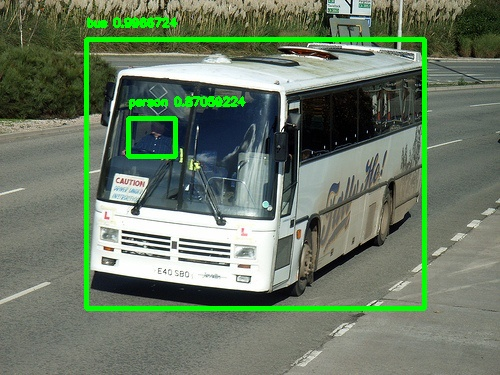

In [23]:
from google.colab.patches import cv2_imshow
#x = cv2.imread("dog_detected.jpg")
x = cv2.imread("bus_detected.jpg")
cv2_imshow(x)

#### References

1. [YOLOv3 Object Detection with Keras](https://towardsdatascience.com/yolo-v3-object-detection-with-keras-461d2cfccef6)

2. [The beginner’s guide to implementing YOLOv3]( https://machinelearningspace.com/yolov3-tensorflow-2-part-1/#nms-unique)